### Figure 2 generation notebook for MERFISH bulk comparisons

In [1]:
import os
import pandas as pd
from matplotlib import pyplot as plt
import matplotlib as mpl
import numpy as np
import anndata
import scanpy as sc
import string
from scipy.stats import pearsonr


mpl.rcParams.update(mpl.rcParamsDefault) #Reset rcParams to default
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']  # Colors in this style

# Plotting style function (run this before plotting the final figure)
def set_plotting_style():
    plt.style.use('seaborn-paper')
    plt.rc('axes', labelsize=12)
    plt.rc('axes', titlesize=12)
    plt.rc('xtick', labelsize=10)
    plt.rc('ytick', labelsize=10)
    plt.rc('legend', fontsize=10)
    plt.rc('text.latex', preamble=r'\usepackage{sfmath}')
    plt.rc('xtick.major', pad=2)
    plt.rc('ytick.major', pad=2)
    plt.rc('mathtext', fontset='stixsans', sf='sansserif')
    plt.rc('figure', figsize=[10,9])
    plt.rc('svg', fonttype='none')

In [2]:
# function to convert the visium Spaceranger output to h5ad/anndata

# This function/script will grab a directory of visium dataset after the spaceranger processing, then convert the outputs to anndata(h5ad) format and will save it to the output_directory.

#Inputs: input_dir, output_dir, 
# (option): library_id (this is optional as we assume that we will use the library_id for the filenames.),
# (option): raw/filtered, default is "filtered", and we will have options for "raw".

# function to convert the visium's spaceranger output to anndata 
def convert_visium_output_to_h5ad(input_dir, output_dir, option):
    # Inputs:
    # input_dir: directory to read out the spaceranger output (usually .../outs/)
    # output_dir: directory to save the anndata result (we will use library_id_visium_raw.h5ad as naming convention)
    # option: "default" is using "filtered_feature_bc_matrix.h5", and "raw" directs to "raw_feature_bc_matrix.h5"
    
    if option=="raw":
        count_file = "raw_feature_bc_matrix.h5"
    else:
        count_file = "filtered_feature_bc_matrix.h5"
        
    # library_id (we assume that the file naming convention follows the suggested structure from the guideline)
    library_id = input_dir.split('/')[-3]
    
    # read the visium spaceranger output files to create an anndata object
    adata = sc.read_visium(input_dir, count_file=count_file, 
                           library_id=library_id, source_image_path=input_dir+"/spatial")
                           
    # spatial embedding for cellxgene
    adata.obsm["X_spatial"] = adata.obsm["spatial"]
    
    # save the anndata as h5ad format in output_dir
    # adata.write_h5ad(output_dir+library_id+"_visium_raw.h5ad")
    return adata

In [3]:
# Load data
dataPath = '/mnt/ibm_lg/spatial-seq/MERlin_Analysis/ProcessedResults/BulkCounts'

experimentNames = ['Msliver_VZG116_021121',
                   'Msliver_VZG116_021221',
                   'Msliver_VZG116_021621',
                   'Msliver_VZG116_021721',
                   'MsLiver_Cellbound_VZG116_V1_JH_09-18-2021',
                   'MsKidney_CellBoundary_VZG116_111921',
                   'MsKidney_CellBoundary_VZG116_121021']
bulkCounts = []

for i in range(len(experimentNames)):
    bulkCounts.append(pd.read_csv(os.path.join(
    dataPath, experimentNames[i] + '_BulkRNACounts.csv')))

print('Bulk RNA counts loaded.')

# MACA data
MACApath = '/mnt/ibm_lg/spatial-seq/BulkRNASeqData/TabulaMurisSenis/'
MACA = pd.read_csv(MACApath + 'GSE132040_190214_A00111_0269_AHH3J3DSXX_190214_A00111_0270_BHHMFWDSXX.csv',
                  index_col=0)
MACA_meta = pd.read_csv(MACApath + 'GSE132040_MACA_Bulk_metadata.csv')

# Use only mice that are 18 months or younger
#ages = ['6','3','18','1','12','9','15']
ages = ['3'] # Use only 3 month old mice
ind = MACA_meta['characteristics: age'].isin(ages)
samplesToKeep = MACA_meta['Sample name'][ind]
samplesToKeep = [s + '.gencode.vM19' for s in samplesToKeep] # Append the suffix to get the sample names consistent

MACA = MACA.loc[:, samplesToKeep]
MACA_meta = MACA_meta.loc[ind]
print('MACA results loaded.')

Bulk RNA counts loaded.
MACA results loaded.


## Public Visium datasets

mouse liver: https://livercellatlas.org/download.php from Spatial proteogenomics paper (link)
mouse kidney: https://www.rebuildingakidney.org/chaise/record/#2/Common:Collection/RID=17-E9J6 (1 dataset, "sham" which was used as a Control in https://jasn.asnjournals.org/content/33/2/279 paper.)

In [4]:
# Load the public visium datasets 
# mouse liver (total of 5 datasets)
visium_liver_path = "/mnt/ibm_lg/spatial-seq/vizgen-MACA-comparison-paper/data/Visium_public/liver/individual_visium_samples/"

files = os.listdir(visium_liver_path)

# define a dataframe to save the result (pseudo-bulk counts per gene)
pseudo_bulk_counts_perGene = pd.DataFrame()

for sample in files:
    adata_temp =  sc.read_10x_h5(visium_liver_path+sample)
    # extract the sample ID from the filename
    sample_id = sample.split(".")[0][-6:]
    df_temp = pd.DataFrame(adata_temp.X.todense(),
                           columns=adata_temp.var_names)
    # compute the pseudo-bulk counts per gene (across ALL Spots)
    pseudo_bulk_counts_perGene.loc[:,sample_id] = np.sum(df_temp,0)

pseudo_bulk_counts_perGene

# compute the average across the replicates
pseudo_bulk_counts_perGene_liver = np.mean(pseudo_bulk_counts_perGene,1)
pseudo_bulk_counts_perGene_liver


# mouse kidney (8-10 weeks old)
visium_kidney_path = "/mnt/ibm_lg/spatial-seq/vizgen-MACA-comparison-paper/data/Visium_public/kidney/fsham_137_processed/outs/"
output_dir = "/mnt/ibm_lg/spatial-seq/vizgen-MACA-comparison-paper/data/Visium_public/kidney/"
visium_kidney =  convert_visium_output_to_h5ad(visium_kidney_path, output_dir, option=False)

df_counts = pd.DataFrame(visium_kidney.X.todense(),
                         columns = visium_kidney.var_names)
df_counts

# sum over all "Spots" for pseudo-bulk counts
pseudo_bulk_counts_perGene_kidney = np.sum(df_counts)
pseudo_bulk_counts_perGene_kidney

print('Visium results loaded.')

Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


Visium results loaded.


### Panel A and B: replicate comparisons in MERFISH liver and kidney

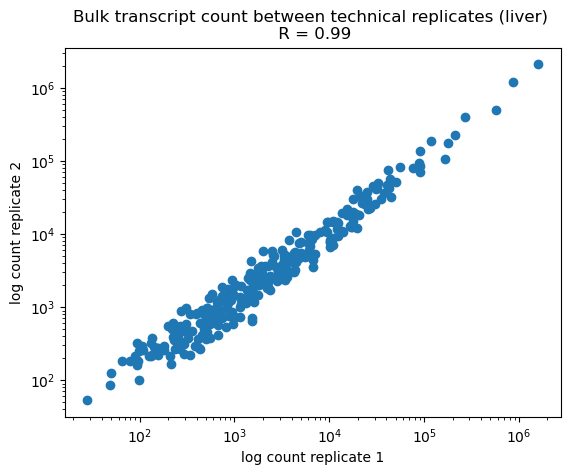

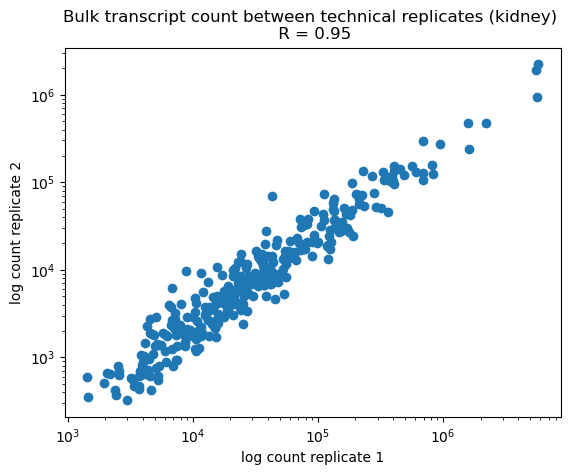

In [5]:
VizgenCountsLiver = []
VizgenCountsKidney = []

liver_ind = [0,1,2,3,4] # Indices of liver experiments
kidney_ind = [5,6] # Indices of kidney experiments

for i in liver_ind:
    VizgenCountsLiver.append(bulkCounts[i])
    
for i in kidney_ind:
    VizgenCountsKidney.append(bulkCounts[i])




# Look at correlation between Vizgen replicates

# Liver

#Pick two sample datasets
i = 0
j = 1

# Calculate correlation coefficient
R2_reps_liver = pearsonr(VizgenCountsLiver[i]['count'],VizgenCountsLiver[j]['count'])[0]

plt.figure()
plt.scatter(VizgenCountsLiver[i]['count'],VizgenCountsLiver[j]['count'])
plt.xlabel('log count replicate 1')
plt.ylabel('log count replicate 2')
plt.xscale('log')
plt.yscale('log')
plt.title('Bulk transcript count between technical replicates (liver) \n R = ' + str(round(R2_reps_liver,2)))
plt.show()

# Kidney

#Pick two sample datasets
i = 0
j = 1

# Calculate correlation coefficient
R2_reps_kidney = pearsonr(VizgenCountsKidney[i]['count'],VizgenCountsKidney[j]['count'])[0]

plt.figure()
plt.scatter(VizgenCountsKidney[i]['count'],VizgenCountsKidney[j]['count'])
plt.xlabel('log count replicate 1')
plt.ylabel('log count replicate 2')
plt.xscale('log')
plt.yscale('log')
plt.title('Bulk transcript count between technical replicates (kidney) \n R = ' + str(round(R2_reps_kidney,2)))
plt.show()

### Panel C: correlation between MERFISH and MACA bulk RNA-seq (VZG116 mouse liver)

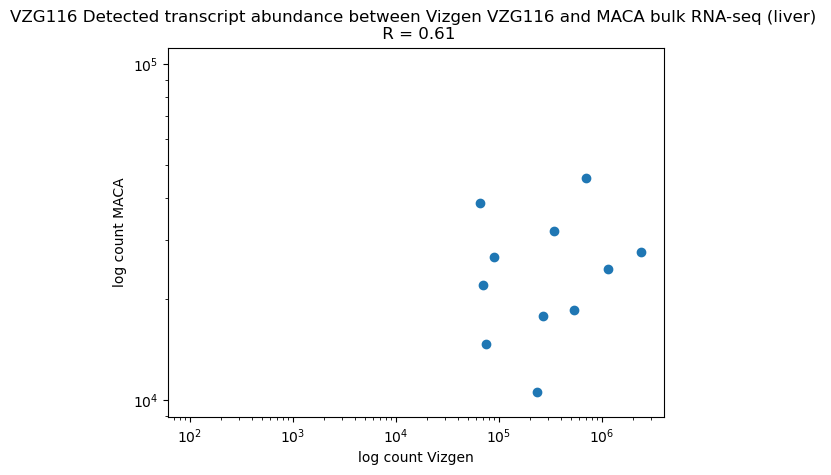

In [6]:
# Format data to be compared

#MACA plates that are liver tissue
liver_plates = MACA_meta['Sample name'].copy()[MACA_meta['source name'].str.contains('Liver')] #Plates containing liver experiments
liver_plate_strings = liver_plates.to_list() #Convert to list of strings
liver_plate_strings = [s + '.gencode.vM19' for s in liver_plate_strings] #Append to every string to make compatible

#Get gene counts from MACA experiments that are liver tissue (reset gene column from index)
MACA_liver = MACA.copy()[liver_plate_strings].reset_index()

#Get the subset of MACA that intersect with Vizgen genes

#First, make gene list lower case
MACA_liver['gene'] = MACA_liver['gene'].str.lower()

#Calculate the average across all bulk RNA_seq experiments
MACA_liver['average'] = MACA_liver.mean(axis=1,skipna=True,numeric_only=True)

#Calculate average across Vizgen replicates

VizgenLiver = pd.DataFrame(data=np.transpose([VizgenCountsLiver[i]['count'] 
                                          for i in range(len(VizgenCountsLiver))]),
                                         columns=[experimentNames[x] for x in liver_ind])
VizgenLiver['average'] = VizgenLiver.mean(axis=1)
VizgenLiver['gene'] = VizgenCountsLiver[0]['gene'].str.lower()

# Rename Vizgen genes that are inconsistent with MACA
# faim3 - fcmr (y)
# mir205hg - 4631405K08Rik (y)
# tmem27 - Cltrn (y)
# gpr116 - Adgrf5 (y)
# emr1 - Adgre1 (y)
# cybasc3 - Cyb561a3 (y)
# ptrf - Cavin1 (y)
# fam159b - Shisal2b (y)
# 1700011H14RIK - ccdc198 (y)
rename_map = {'faim3':'fcmr',
              'mir205hg':'4631405k08rik',
             'tmem27':'cltrn',
             'gpr116':'adgrf5',
             'emr1':'adgre1',
             'cybasc3':'cyb561a3',
             'ptrf':'cavin1',
             'fam159b':'shisal2b',
             '1700011h14rik':'ccdc198'}
for i in range(VizgenLiver.shape[0]):
    if VizgenLiver.loc[i,'gene'] in rename_map.keys():
        VizgenLiver.loc[i,'gene'] = rename_map[VizgenLiver.loc[i,'gene']]

# Get the intersection_liver with common genes
intersection_liver = VizgenLiver[['average','gene']].merge(MACA_liver[['average','gene']],
                                                           on='gene')
intersection_liver = intersection_liver.rename(columns={'average_x':'Vizgen_avg', 'average_y':'MACA_avg'})


# Plot results

# Correlation coefficient
R2_compare_liver = pearsonr(intersection_liver['Vizgen_avg'], intersection_liver['MACA_avg'])[0]

# Scatter plot of averages
plt.figure()
plt.scatter(intersection_liver['Vizgen_avg'], intersection_liver['MACA_avg'])
plt.xscale('log')
plt.yscale('log')
plt.xlabel('log count Vizgen')
plt.ylabel('log count MACA')
plt.title('VZG116 Detected transcript abundance between Vizgen VZG116 and MACA bulk RNA-seq (liver) \n R = ' 
          + str(round(R2_compare_liver,2)))

plt.show()

### Panel D: correlation between MERFISH and MACA bulk RNA-seq (VZG116 mouse kidney)

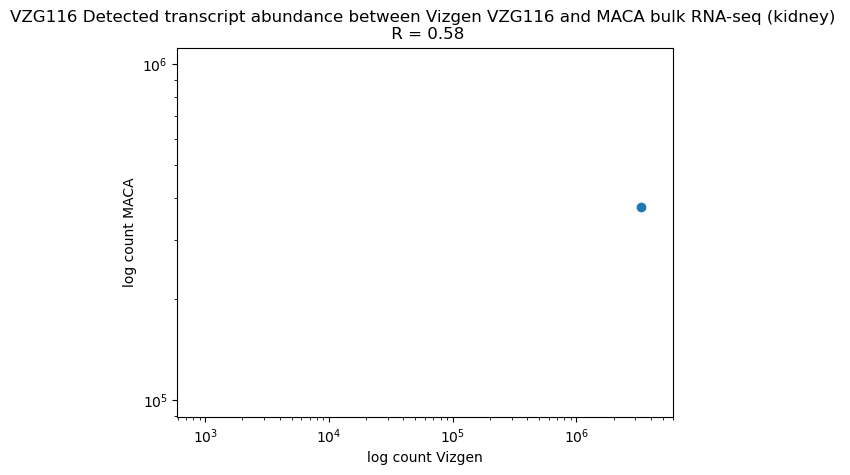

In [7]:
# Format data to be compared

#MACA plates that are kidney tissue
kidney_plates = MACA_meta['Sample name'].copy()[MACA_meta['source name'].str.contains('Kidney')] #Plates containing kidney experiments
kidney_plate_strings = kidney_plates.to_list() #Convert to list of strings
kidney_plate_strings = [s + '.gencode.vM19' for s in kidney_plate_strings] #Append to every string to make compatible

#Get gene counts from MACA experiments that are kidney tissue (reset gene column from index)
MACA_kidney = MACA.copy()[kidney_plate_strings].reset_index()

#Get the subset of MACA that intersect with Vizgen genes
#First, make gene list lower case
MACA_kidney['gene'] = MACA_kidney['gene'].str.lower()

#Calculate the average across all bulk RNA_seq experiments
MACA_kidney['average'] = MACA_kidney.mean(axis=1,skipna=True,numeric_only=True)

#Calculate average across Vizgen replicates

VizgenKidney = pd.DataFrame(data=np.transpose([VizgenCountsKidney[i]['count'] 
                                          for i in range(len(VizgenCountsKidney))]),
                                         columns=[experimentNames[x] for x in kidney_ind])
VizgenKidney['average'] = VizgenKidney.mean(axis=1)
VizgenKidney['gene'] = VizgenCountsKidney[0]['gene'].str.lower()

# Rename Vizgen genes that are inconsistent with MACA
for i in range(VizgenKidney.shape[0]):
    if VizgenKidney.loc[i,'gene'] in rename_map.keys():
        VizgenKidney.loc[i,'gene'] = rename_map[VizgenKidney.loc[i,'gene']]

# Get the intersection_kidney with common genes
intersection_kidney = VizgenKidney[['average','gene']].merge(MACA_kidney[['average','gene']],
                                                           on='gene')
intersection_kidney = intersection_kidney.rename(columns={'average_x':'Vizgen_avg', 'average_y':'MACA_avg'})


# Plot results

# Correlation coefficient
R2_compare_kidney = pearsonr(intersection_kidney['Vizgen_avg'], intersection_kidney['MACA_avg'])[0]

# Scatter plot of averages
plt.figure()
plt.scatter(intersection_kidney['Vizgen_avg'], intersection_kidney['MACA_avg'])
plt.xscale('log')
plt.yscale('log')
plt.xlabel('log count Vizgen')
plt.ylabel('log count MACA')
plt.title('VZG116 Detected transcript abundance between Vizgen VZG116 and MACA bulk RNA-seq (kidney) \n R = ' 
          + str(round(R2_compare_kidney,2)))

plt.show()

### Panel E: correlation between MERFISH and Visium bulk RNA-seq (VZG116 mouse liver)

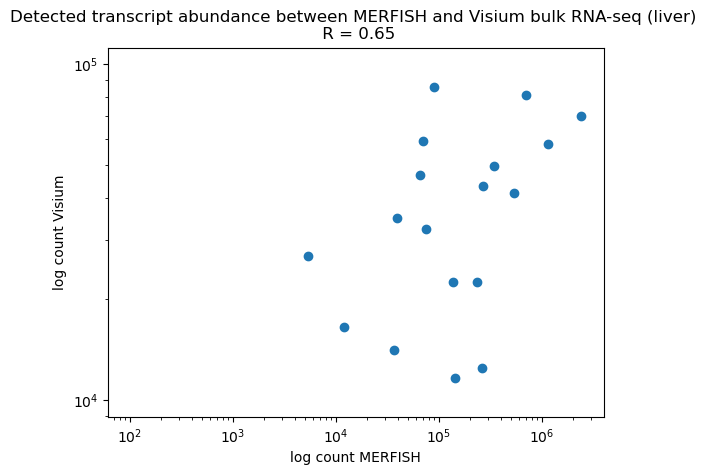

In [8]:
# Format data to be compared
#List of genes to be examined
genes = VizgenCountsLiver[0]['gene'].copy()
gene_list = genes.to_list() #Get gene list

gene_list = [x.lower() for x in gene_list] #Convert to lower case

#Calculate average across Vizgen replicates
VizgenLiver = pd.DataFrame(data=np.transpose([VizgenCountsLiver[i]['count'] 
                                          for i in range(len(VizgenCountsLiver))]),
                                         columns=[experimentNames[x] for x in liver_ind])
VizgenLiver['average'] = VizgenLiver.mean(axis=1)
VizgenLiver['gene'] = VizgenCountsLiver[0]['gene'].str.lower()

# Calculate the average across Visium experiments 
pseudo_bulk_counts_perGene_liver

# make the gene names as lower case
pseudo_bulk_counts_perGene_liver.index = pseudo_bulk_counts_perGene_liver.index.str.lower()
pseudo_bulk_counts_perGene_liver

df_visium_liver = pd.DataFrame(pseudo_bulk_counts_perGene_liver)
df_visium_liver = df_visium_liver.rename(columns={0:"average"})
df_visium_liver["gene"] = df_visium_liver.index
df_visium_liver.index = np.arange(0,len(df_visium_liver))
df_visium_liver

# Rename Vizgen and Visium genes that are inconsistent with MACA
# faim3 - fcmr (y)
# mir205hg - 4631405K08Rik (y)
# tmem27 - Cltrn (y)
# gpr116 - Adgrf5 (y)
# emr1 - Adgre1 (y)
# cybasc3 - Cyb561a3 (y)
# ptrf - Cavin1 (y)
# fam159b - Shisal2b (y)
# 1700011H14RIK - ccdc198 (y)
rename_map = {'faim3':'fcmr',
              'mir205hg':'4631405k08rik',
             'tmem27':'cltrn',
             'gpr116':'adgrf5',
             'emr1':'adgre1',
             'cybasc3':'cyb561a3',
             'ptrf':'cavin1',
             'fam159b':'shisal2b',
             '1700011h14rik':'ccdc198'}
for i in range(VizgenLiver.shape[0]):
    if VizgenLiver.loc[i,'gene'] in rename_map.keys():
        VizgenLiver.loc[i,'gene'] = rename_map[VizgenLiver.loc[i,'gene']]

for i in range(df_visium_liver["gene"].shape[0]):
    if df_visium_liver.loc[i,"gene"] in rename_map.keys():
        df_visium_liver.loc[i,"gene"] = rename_map[df_visium_liver.loc[i,"gene"]]

        
# Get the intersection_liver with common genes
intersection_liver_visium = VizgenLiver[['average','gene']].merge(df_visium_liver[['average','gene']],
                                                           on='gene')
intersection_liver_visium = intersection_liver_visium.rename(columns={'average_x':'Vizgen_avg', 'average_y':'Visium_avg'})


# Plot results

# Correlation coefficient
R2_compare_liver_visium = np.corrcoef(intersection_liver_visium['Vizgen_avg'], intersection_liver_visium['Visium_avg'])
R2_compare_liver_visium = R2_compare_liver_visium[1,0]

# Scatter plot of averages
plt.figure()
plt.scatter(intersection_liver_visium['Vizgen_avg'], intersection_liver_visium['Visium_avg'])
plt.xscale('log')
plt.yscale('log')
plt.xlabel('log count MERFISH')
plt.ylabel('log count Visium')
plt.title('Detected transcript abundance between MERFISH and Visium bulk RNA-seq (liver) \n R = ' 
          + str(round(R2_compare_liver_visium,2)))

plt.show()

### Panel F: correlation between MERFISH and Visium bulk RNA-seq (VZG116 mouse kidney)

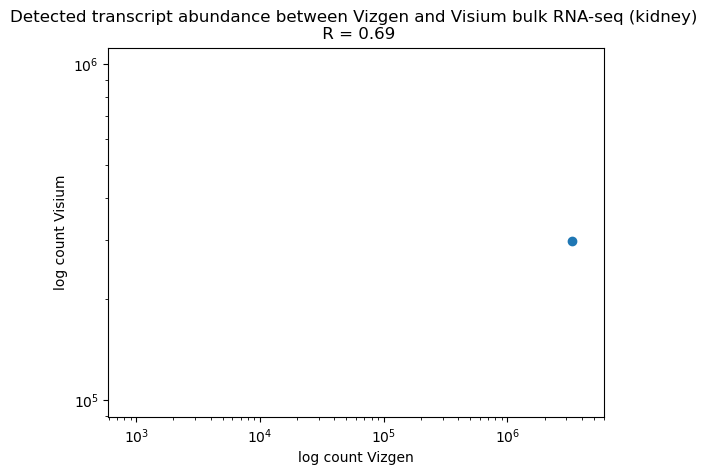

In [9]:
# Format data to be compared
#List of genes to be examined
genes = VizgenCountsKidney[0]['gene'].copy()
gene_list = genes.to_list() #Get gene list
gene_list = [x.lower() for x in gene_list] #Convert to lower case

#Calculate average across Vizgen replicates

VizgenKidney = pd.DataFrame(data=np.transpose([VizgenCountsKidney[i]['count'] 
                                         for i in range(len(VizgenCountsKidney))]),
                                        columns=[experimentNames[x] for x in kidney_ind])
VizgenKidney['average'] = VizgenKidney.mean(axis=1)
VizgenKidney['gene'] = VizgenCountsKidney[0]['gene'].str.lower()

# Rename Vizgen genes that are inconsistent with MACA
for i in range(VizgenKidney.shape[0]):
    if VizgenKidney.loc[i,'gene'] in rename_map.keys():
        VizgenKidney.loc[i,'gene'] = rename_map[VizgenKidney.loc[i,'gene']]


# Calculate the average across Visium experiments 
pseudo_bulk_counts_perGene_kidney

# make the gene names as lower case
pseudo_bulk_counts_perGene_kidney.index = pseudo_bulk_counts_perGene_kidney.index.str.lower()
pseudo_bulk_counts_perGene_kidney

df_visium_kidney = pd.DataFrame(pseudo_bulk_counts_perGene_kidney)
df_visium_kidney = df_visium_kidney.rename(columns={0:"average"})
df_visium_kidney["gene"] = df_visium_kidney.index
df_visium_kidney



# Get the intersection_kidney with common genes
intersection_kidney_visium = VizgenKidney[['average','gene']].merge(df_visium_kidney[['average','gene']],
                                                           on='gene')
intersection_kidney_visium = intersection_kidney_visium.rename(columns={'average_x':'Vizgen_avg', 'average_y':'Visium_avg'})


# Plot results

# Correlation coefficient
R2_compare_kidney_visium = np.corrcoef(intersection_kidney_visium['Vizgen_avg'], intersection_kidney_visium['Visium_avg'])
R2_compare_kidney_visium = R2_compare_kidney_visium[1,0]

# Scatter plot of averages
plt.figure()
plt.scatter(intersection_kidney_visium['Vizgen_avg'], intersection_kidney_visium['Visium_avg'])
plt.xscale('log')
plt.yscale('log')
plt.xlabel('log count Vizgen')
plt.ylabel('log count Visium')
plt.title('Detected transcript abundance between Vizgen and Visium bulk RNA-seq (kidney) \n R = ' 
          + str(round(R2_compare_kidney_visium,2)))

plt.show()

### Panel G: histogram of ratio of counts per gene in liver (averaged across experiments)

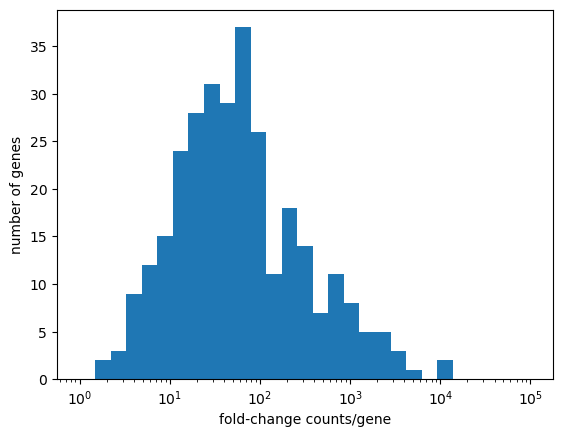

In [10]:
bins = np.logspace(0,5,30)

plt.figure()
plt.hist(intersection_liver['Vizgen_avg'] / intersection_liver['MACA_avg'], bins=bins)
plt.xlabel('fold-change counts/gene')
plt.ylabel('number of genes')
plt.xscale('log')

plt.show()

### Panel H: histogram of counts per gene in kidney (averaged across experiments)

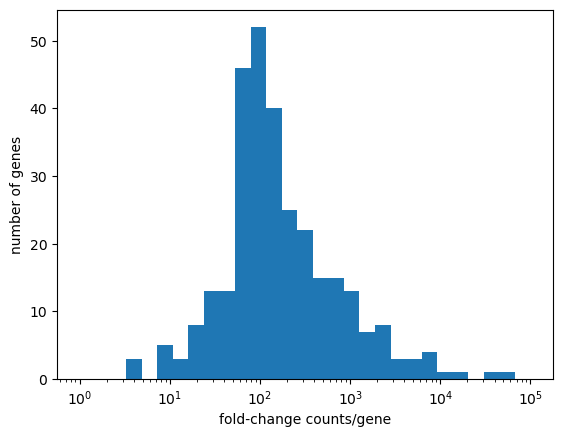

In [11]:
bins = np.logspace(0,5,30)

plt.figure()
plt.hist(intersection_kidney['Vizgen_avg'] / intersection_kidney['MACA_avg'], bins=bins)
plt.xlabel('fold-change counts/gene')
plt.ylabel('number of genes')
plt.xscale('log')

plt.show()

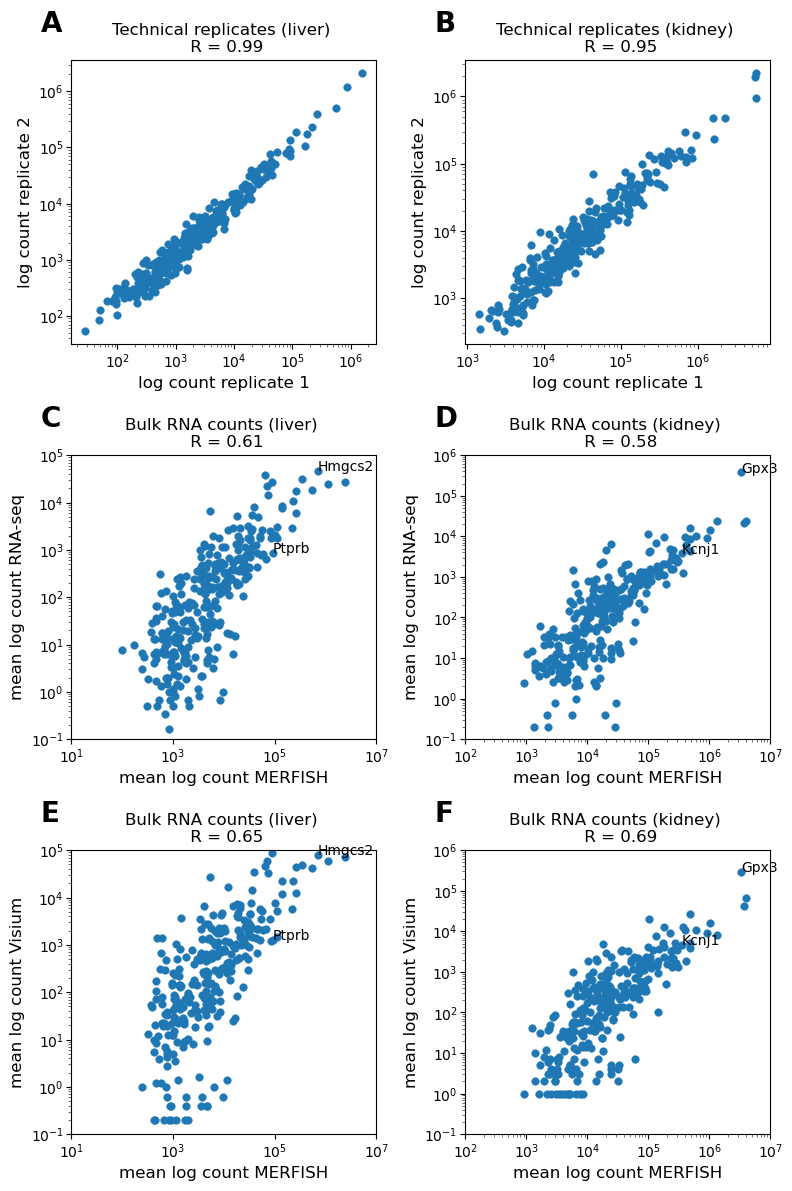

In [14]:
set_plotting_style()
# Plot the whole figure
fig, axes = plt.subplots(3,2, figsize=(8,12))

# Panel A
i = 0
j = 1
ax = axes[0,0]
ax.scatter(VizgenCountsLiver[i]['count'],VizgenCountsLiver[j]['count'])
ax.set_xlabel('log count replicate 1')
ax.set_ylabel('log count replicate 2')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_title('Technical replicates (liver) \n R = ' + str(round(R2_reps_liver,2)))

# Panel B
i = 0
j = 1
ax = axes[0,1]
ax.scatter(VizgenCountsKidney[i]['count'],VizgenCountsKidney[j]['count'])
ax.set_xlabel('log count replicate 1')
ax.set_ylabel('log count replicate 2')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_title('Technical replicates (kidney) \n R = ' + str(round(R2_reps_kidney,2)))

# Panel C
ax = axes[1,0]
ax.scatter(intersection_liver['Vizgen_avg'], intersection_liver['MACA_avg'])
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlim((1e1,1e7))
ax.set_ylim((1e-1,1e5))
ax.set_xlabel('mean log count MERFISH')
ax.set_ylabel('mean log count RNA-seq')
ax.set_title('Bulk RNA counts (liver) \n R = ' 
          + str(round(R2_compare_liver,2)))

# Annotate some genes
hmgcs2 = intersection_liver[intersection_liver['gene'] == 'hmgcs2']
ptprb = intersection_liver[intersection_liver['gene'] == 'ptprb']

ax.text(hmgcs2['Vizgen_avg'], hmgcs2['MACA_avg'], 'Hmgcs2')
ax.text(ptprb['Vizgen_avg'], ptprb['MACA_avg'], 'Ptprb')

                  
# Panel D
ax = axes[1,1]
ax.scatter(intersection_kidney['Vizgen_avg'], intersection_kidney['MACA_avg'])
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlim((1e2,1e7))
ax.set_ylim((1e-1,1e6))
ax.set_xlabel('mean log count MERFISH')
ax.set_ylabel('mean log count RNA-seq')
ax.set_title('Bulk RNA counts (kidney) \n R = ' 
          + str(round(R2_compare_kidney,2)))

# Annotate some genes
gpx3 = intersection_kidney[intersection_kidney['gene'] == 'gpx3']
kcnj1 = intersection_kidney[intersection_kidney['gene'] == 'kcnj1']

ax.text(gpx3['Vizgen_avg'], gpx3['MACA_avg'], 'Gpx3')
ax.text(kcnj1['Vizgen_avg'], kcnj1['MACA_avg'], 'Kcnj1')

# MERFISH vs Visium
# Panel E
ax = axes[2,0]
ax.scatter(intersection_liver_visium['Vizgen_avg'], intersection_liver_visium['Visium_avg'])
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlim((1e1,1e7))
ax.set_ylim((1e-1,1e5))
ax.set_xlabel('mean log count MERFISH')
ax.set_ylabel('mean log count Visium')
ax.set_title('Bulk RNA counts (liver) \n R = ' 
          + str(round(R2_compare_liver_visium,2)))

# Annotate some genes
hmgcs2 = intersection_liver_visium[intersection_liver_visium['gene'] == 'hmgcs2']
ptprb = intersection_liver_visium[intersection_liver_visium['gene'] == 'ptprb']

ax.text(hmgcs2['Vizgen_avg'], hmgcs2['Visium_avg'], 'Hmgcs2')
ax.text(ptprb['Vizgen_avg'], ptprb['Visium_avg'], 'Ptprb')

                  
# Panel F
ax = axes[2,1]
ax.scatter(intersection_kidney_visium['Vizgen_avg'], intersection_kidney_visium['Visium_avg'])
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlim((1e2,1e7))
ax.set_ylim((1e-1,1e6))
ax.set_xlabel('mean log count MERFISH')
ax.set_ylabel('mean log count Visium')
ax.set_title('Bulk RNA counts (kidney) \n R = ' 
          + str(round(R2_compare_kidney_visium,2)))

# Annotate some genes
gpx3 = intersection_kidney_visium[intersection_kidney_visium['gene'] == 'gpx3']
kcnj1 = intersection_kidney_visium[intersection_kidney_visium['gene'] == 'kcnj1']

ax.text(gpx3['Vizgen_avg'], gpx3['Visium_avg'], 'Gpx3')
ax.text(kcnj1['Vizgen_avg'], kcnj1['Visium_avg'], 'Kcnj1')

# # Panel G
# ax = axes[2,0]
# bins = np.logspace(0,5,30)

# ax.hist(intersection_liver['Vizgen_avg'] / intersection_liver['MACA_avg'], bins=bins)
# ax.set_xlabel('fold-change mean counts/gene')
# ax.set_ylabel('number of genes')
# ax.set_xscale('log')
# #ax.legend()
# #ax.set_title('counts per gene, liver')

# # Panel H
# ax = axes[2,1]
# bins = np.logspace(0,5,30)

# ax.hist(intersection_kidney['Vizgen_avg'] / intersection_kidney['MACA_avg'], bins=bins)
# ax.set_xlabel('fold-change mean counts/gene')
# ax.set_ylabel('number of genes')
# ax.set_xscale('log')
# #ax.legend()
# #ax.set_title('counts per gene, kidney')

# Label subpanels
axes_flat = axes.flat
for n, ax in enumerate(axes_flat):
    ax.text(-0.1, 1.1, string.ascii_uppercase[n], transform=ax.transAxes, 
            size=20, weight='bold')

fig.tight_layout()
plt.show()

In [15]:
# Export figures
fig.savefig('../../figures/Fig2_bulkanalysis.svg', transparent=True)
fig.savefig('../../figures/Fig2_bulkanalysis.png', transparent=True)
fig.savefig('../../figures/Fig2_bulkanalysis.pdf', transparent=True)

print('Figures saved.')

Figures saved.
